In [1]:
from pyDeepInsight import ImageTransformer
from pyDeepInsight.utils import Norm2Scaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = '/home/ec2-user/MLNotebooks/'

#### Process the dataframe and split

In [3]:
df = pd.read_csv(path + 'Datasets/kr_ScrambledRow_0922.csv')

df.drop(['Unnamed: 0', 'Gene'], axis=1, inplace=True)
df.dropna(axis=0, inplace=True)
y = df['Localization'].values
X = df.iloc[:, :-1].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)

In [4]:
np.unique(y, return_counts=True)

(array(['Cytosol', 'Mitochondria', 'Nuclear', 'Secretory'], dtype=object),
 array([2803,  463, 1703, 1204]))

In [5]:
X_train.shape

(4938, 244)

In [6]:
y_train

array(['Secretory', 'Nuclear', 'Secretory', ..., 'Cytosol', 'Cytosol',
       'Nuclear'], dtype=object)

#### Normalize data using Sigmoid function and encode classes

In [7]:
def sigmoid(x):
    return (x + 3) / 6
X_train_norm = np.apply_along_axis(sigmoid, axis=1, arr=X_train)
X_valid_norm = np.apply_along_axis(sigmoid, axis=1, arr=X_valid)

In [8]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_valid_enc = le.transform(y_valid)
num_classes = np.unique(y_train_enc).size

In [9]:
y_valid_enc

array([3, 2, 1, ..., 0, 2, 0])

#### Create t-SNE object

In [10]:
distance_metric = 'cosine'
reducer = TSNE(
    n_components=2,
    metric=distance_metric,
    init='random',
    learning_rate='auto',
    n_jobs=-1
)

#### Initalize image transformer

In [11]:
pixel_size = (64,64)
it = ImageTransformer(
    feature_extractor=reducer, 
    pixels=pixel_size)

#### Train image transformer

/home/ec2-user/miniconda3/envs/deeplearning/lib/python3.11/site-packages/pyDeepInsight/image_transformer.py:270: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_new[:, 0], x_new[:, 1], s=1,


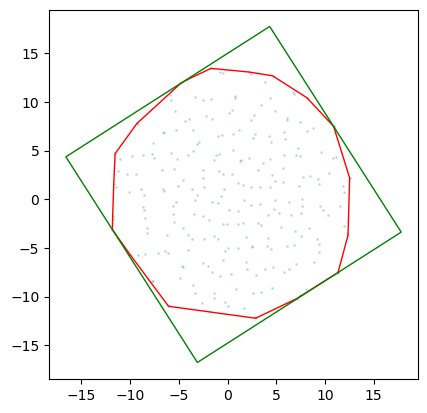

In [12]:
it.fit(X_train, y=y_train, plot=True)
X_train_img = it.transform(X_train_norm)
X_valid_img = it.transform(X_valid_norm)

In [13]:
len(X_train_img)

4938

#### feature density

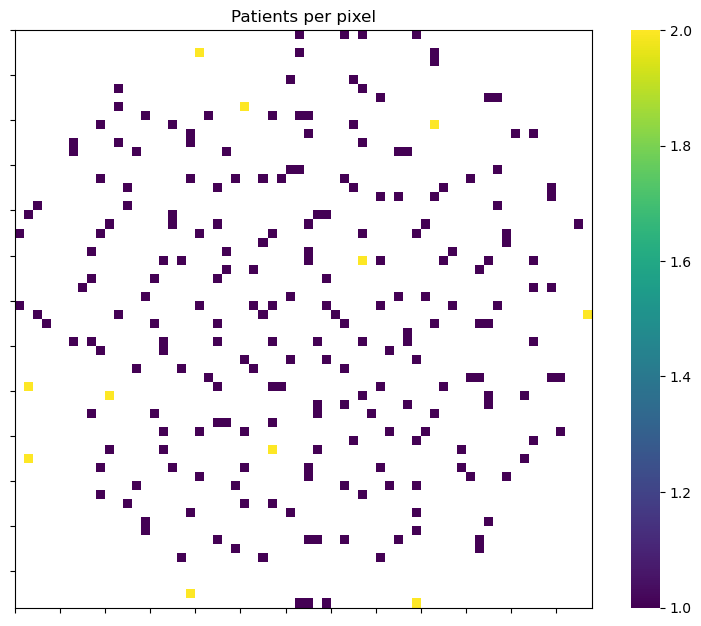

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

fdm = it.feature_density_matrix()
fdm[fdm == 0] = np.nan

plt.figure(figsize=(10, 7.5))

ax = sns.heatmap(fdm, cmap="viridis", linewidths=0., 
                 linecolor="lightgrey", square=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
for _, spine in ax.spines.items():
    spine.set_visible(True)
_ = plt.title("Patients per pixel")

#### Sample image in the training set and validation set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


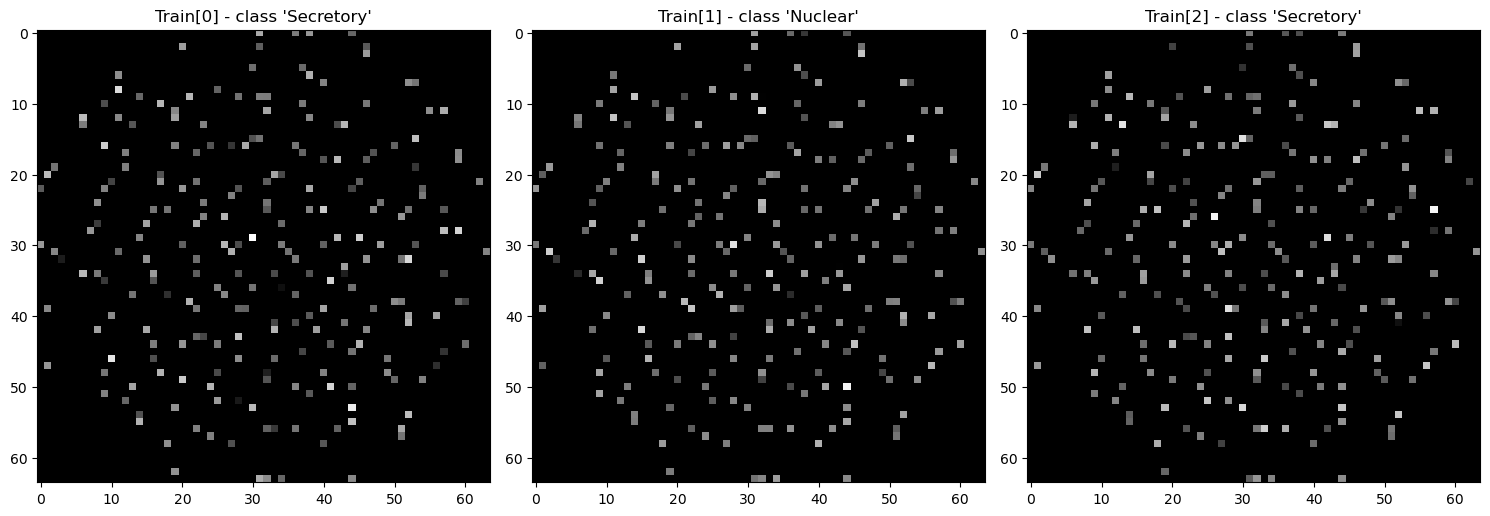

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(X_train_img[i])
    ax[i].title.set_text(f"Train[{i}] - class '{y_train[i]}'")
plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


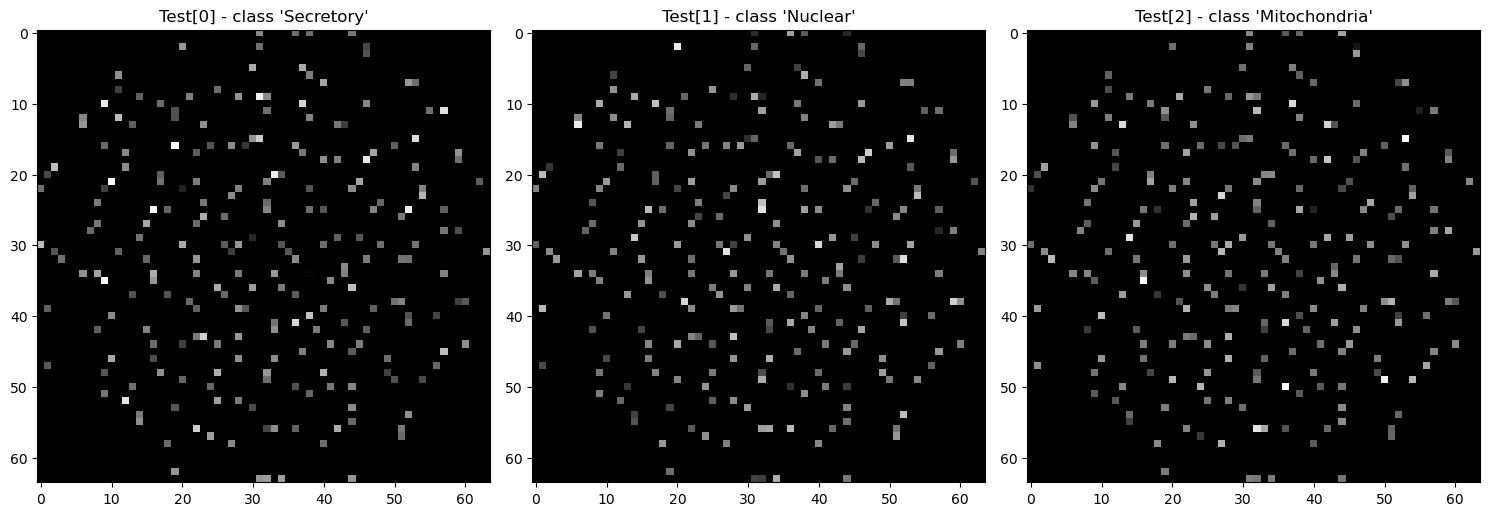

In [16]:
X_valid_img = it.transform(X_valid_norm)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(X_valid_img[i])
    ax[i].title.set_text(f"Test[{i}] - class '{y_valid[i]}'")
plt.tight_layout()

#### SequeezeNet

In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

import warnings; 
warnings.simplefilter('ignore')

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Modify PyTrorch SqueezeNet 1.1 output to number of classes

In [19]:
model = torchvision.models.squeezenet1_1(weights='DEFAULT')
model.classifier.append(nn.Flatten())
_ = model.classifier.append(nn.Linear(1000, num_classes))

#### Transform numpy image format to PyTorch tensor. Using an untrained network, so normalization as specificed in SqueezeNet documentation is not required.

In [20]:
preprocess = transforms.Compose([
    transforms.ToTensor()
])

In [21]:
X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float()
y_train_tensor = torch.from_numpy(le.fit_transform(y_train))

X_valid_tensor = torch.stack([preprocess(img) for img in X_valid_img]).float()
y_valid_tensor = torch.from_numpy(le.transform(y_valid))

#### Generate pyTorch datasets and dataloaders for training and testing sets.

In [22]:
batch_size = 32

trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

validset = TensorDataset(X_valid_tensor, y_valid_tensor)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False)

#### Specify loss function and optimization algorithm

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-04,
    #momentum=0.8,
    weight_decay=1e-05
)

#### Training for epochs

In [24]:
PerformanceDF = pd.DataFrame(index=range(100),columns=['Epoch','TrainAcc','ValAcc'])

for epoch in range(100):
    model.train()
    model.to(device)

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    with torch.no_grad():
        model.to('cpu')
        model = model.eval()

        y_hat_train = model(X_train_tensor)
        y_hat_valid = model(X_valid_tensor)

        train_predicted = torch.max(y_hat_train, 1)[1]
        train_accu = accuracy_score(train_predicted, y_train_tensor)
            
        valid_predicted = torch.max(y_hat_valid, 1)[1]
        valid_accu = accuracy_score(valid_predicted, y_valid_tensor)
        
    PerformanceDF.loc[epoch,:]=[epoch,train_accu,valid_accu]
    
    # print epoch statistics
    # print epoch statistics
    if not (epoch % 20):
        print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.3f}, Train Accuracy: {train_accu}, Valid_Accuracy: {valid_accu}')

[0] loss: 1.296, Train Accuracy: 0.45402997164844067, Valid_Accuracy: 0.454251012145749
[20] loss: 1.226, Train Accuracy: 0.45402997164844067, Valid_Accuracy: 0.454251012145749
[40] loss: 1.074, Train Accuracy: 0.4538274605103281, Valid_Accuracy: 0.45587044534412957
[60] loss: 0.459, Train Accuracy: 0.8687727825030377, Valid_Accuracy: 0.30121457489878545
[80] loss: 0.062, Train Accuracy: 0.9708383961117861, Valid_Accuracy: 0.340080971659919


#### Calculate accuracy

In [25]:
model.to('cpu')
model = model.eval()

In [26]:
with torch.no_grad():
    y_hat = model(X_valid_tensor)
valid_predicted = torch.max(y_hat, 1)[1]

In [27]:
print(f"The test accuracy was {accuracy_score(valid_predicted, y_valid_tensor):.3f}")

The test accuracy was 0.332


#### Confusion matrix

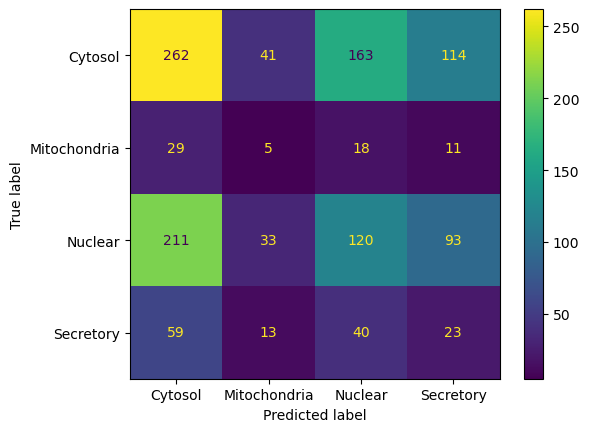

In [28]:
_ = ConfusionMatrixDisplay.from_predictions(valid_predicted, y_valid_tensor, display_labels=le.classes_)

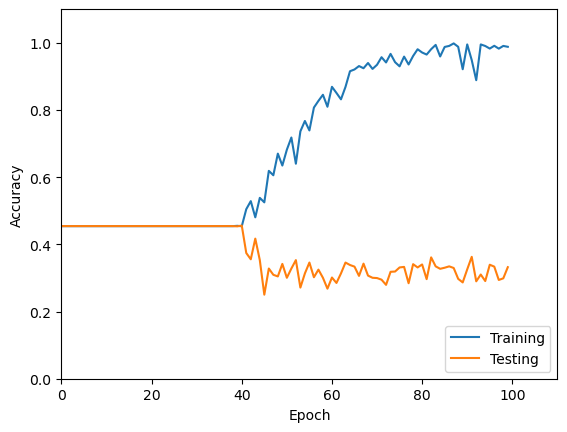

In [29]:
# Graph accuracy for training and validation

import matplotlib.pyplot as plt
plt.plot(PerformanceDF['Epoch'], PerformanceDF['TrainAcc'])
plt.plot(PerformanceDF['Epoch'], PerformanceDF['ValAcc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1.1])
plt.xlim([0,110])
plt.legend(['Training', 'Testing'], loc='lower right')
plt.savefig(path+'/DeepInsight-NN/krug_scrambledrow_deepinsightnn_tsne.pdf')
plt.show()